In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision.datasets import ImageFolder
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

import torch
from torch import nn


import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


np.random.seed(123)
torch.manual_seed(123)

def resize_transformation(img):
  resize = transforms.Compose([transforms.Resize([64,64]),
  transforms.ToTensor(),transforms.Grayscale()])
  i = resize(img)
  i =i*255.0 #back to 0-255
  return i


train_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/train'
test_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/test'


train=ImageFolder(root=train_path,transform=resize_transformation)
test=ImageFolder(root=test_path,transform=resize_transformation)


train_size=int(0.85*len(train))
validation_size=len(train)-train_size
training_set,validation_set=torch.utils.data.random_split(train,[train_size,validation_size])

batch_size = 32
train_loader = DataLoader(training_set, batch_size=batch_size,shuffle=True,pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size,shuffle=False,pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size,shuffle=False,pin_memory=True)


In [12]:
class simpleCNN(nn.Module): #Basic CNN
  def __init__(self):
    super(simpleCNN,self).__init__() #initialize the model

    self.conv1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1) #Output image size is (size+2*padding-kernel)/stride +1-->62*62
    self.relu1=nn.ReLU()
    self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2) #outtput image 62/2-->31*31

    self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1) #output image is 29*29
    self.relu2=nn.ReLU()
    self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=2) #output image is 29/2-->14*14  (MaxPool2d approximates size with floor)

    self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1) #output image is 12*12
    self.relu3=nn.ReLU()

    self.fc1=nn.Linear(32*12*12,15) #16 channels * 12*12 image (64*64 with 2 maxpooling of stride 2), 15 output features=15 classes

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu1(x)
    x=self.maxpool1(x)

    x=self.conv2(x)
    x=self.relu2(x)
    x=self.maxpool2(x)

    x=self.conv3(x)
    x=self.relu3(x)

    x=x.view(-1,32*12*12)

    x=self.fc1(x)

    return x


In [13]:
def init_weights(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear):
    nn.init.normal_(m.weight,0,0.01)
    nn.init.zeros_(m.bias)


model = simpleCNN()
model.apply(init_weights)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.0004,momentum=0.9)

In [14]:
def train_one_epoch(model,epoch_index,loader,loss_function,optimizer):
  running_loss=0

  for i, data in enumerate(loader):

    inputs,labels=data #get the minibatch

    outputs=model(inputs) #forward pass

    loss=loss_function(outputs,labels) #compute loss
    running_loss+=loss.item() #sum up the loss for the minibatches processed so far

    optimizer.zero_grad() #reset gradients
    loss.backward() #compute gradient
    optimizer.step() #update weights

  return running_loss/(i+1) # average loss per minibatch


def train_model(model,train_loader,validation_loader,loss_function,optimizer,EPOCHS):
  best_validation_loss=np.inf

  train_losses = []
  validation_losses = []
  validation_accuracies = []

  start_time=time.time()
  for epoch in range(EPOCHS):
    print('EPOCH{}:'.format(epoch+1))

    model.train(True)
    train_loss=train_one_epoch(model,epoch,train_loader,loss_function,optimizer) ##train for each epoch

    running_validation_loss=0.0

    model.eval()

    with torch.no_grad(): # Disable gradient computation and reduce memory consumption
      correct=0
      total=0
      for i,vdata in enumerate(validation_loader):
        vinputs,vlabels=vdata
        voutputs=model(vinputs)
        _,predicted=torch.max(voutputs.data,1)
        vloss=loss_function(voutputs,vlabels)
        running_validation_loss+=vloss
        total+=vlabels.size(0)
        correct+=(predicted==vlabels).sum().item()
    validation_loss=running_validation_loss/(i+1)
    validation_acc = 100*correct/total
    print(f'LOSS train: {train_loss} validation: {validation_loss} | validation_accuracy: {validation_acc}% ')

    if validation_loss<best_validation_loss: #save the model if it's the best so far
      timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')
      best_validation_loss=validation_loss
      model_path='model_{}_{}'.format(timestamp,epoch)
      torch.save(model.state_dict(),model_path)

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_acc)

  end_time=time.time()

  plt.plot(train_losses, color='tab:red', linewidth=3, label='train loss')
  validation_losses_np = torch.stack(validation_losses).cpu().numpy() #move validation losses to cpu to plot with matplotlib
  plt.plot(validation_losses_np, color='tab:green', linewidth=3, label='validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('CE loss')

  ax_right = plt.gca().twinx()
  #validation_accuracies_np = torch.stack(validation_accuracies).cpu().numpy() #move validation accuracies to cpu to plot with matplotlib
  ax_right.plot(validation_accuracies, color='tab:green', linestyle='--', label='validation accuracy')
  ax_right.set_ylabel('accuracy (%)')

  plt.gcf().legend(ncol=3)
  plt.gcf().set_size_inches(6, 3)

  print(f"Time: {end_time-start_time}")
  return model_path

EPOCH1:
LOSS train: 2.708435279130936 validation: 2.7081289291381836 | validation_accuracy: 5.333333333333333% 
EPOCH2:
LOSS train: 2.708067035675049 validation: 2.707836151123047 | validation_accuracy: 4.444444444444445% 
EPOCH3:
LOSS train: 2.7079160869121552 validation: 2.7078142166137695 | validation_accuracy: 5.777777777777778% 
EPOCH4:
LOSS train: 2.7078241765499116 validation: 2.7078561782836914 | validation_accuracy: 5.333333333333333% 
EPOCH5:
LOSS train: 2.707683044672012 validation: 2.707723617553711 | validation_accuracy: 6.666666666666667% 
EPOCH6:
LOSS train: 2.7075240194797514 validation: 2.707754373550415 | validation_accuracy: 4.444444444444445% 
EPOCH7:
LOSS train: 2.707418382167816 validation: 2.707524538040161 | validation_accuracy: 4.444444444444445% 
EPOCH8:
LOSS train: 2.707244670391083 validation: 2.7074363231658936 | validation_accuracy: 4.0% 
EPOCH9:
LOSS train: 2.7069643139839172 validation: 2.7070322036743164 | validation_accuracy: 5.777777777777778% 
EPOCH1

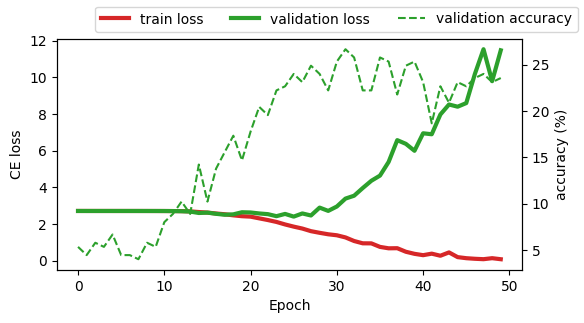

In [15]:
model_path=train_model(model,train_loader,validation_loader,loss_function,optimizer,50)